<a href="https://colab.research.google.com/github/mrinaaall/OkCupid/blob/main/OkCupid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

In [2]:
missing_values = ["n/a", "na", "--", '-1', "NaN"]
profile_data = pd.read_csv('/content/drive/MyDrive/profiles.csv', encoding = 'utf8', na_values = missing_values)

In [3]:
profile_data.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [4]:
profile_data.dtypes

age              int64
body_type       object
diet            object
drinks          object
drugs           object
education       object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
ethnicity       object
height         float64
income         float64
job             object
last_online     object
location        object
offspring       object
orientation     object
pets            object
religion        object
sex             object
sign            object
smokes          object
speaks          object
status          object
dtype: object

In [5]:
profile_data.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,NaN,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000.0,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,NaN,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,white,71.0,20000.0,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN,"asian, black, other",66.0,NaN,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


In [6]:
# Eliminating the Chained Assignment error.
pd.set_option('mode.chained_assignment', None)

In [7]:
profile_data = profile_data.dropna()

-----------------------

Profile Demographics:

In [8]:
'''
Creating a date-time object from the feature: last_online.
'''
profile_data['last_online'] = pd.to_datetime(profile_data.last_online, format='%Y-%m-%d-%H-%M')

'''
Splitting DATETIME instance of last_online into Date AND Time.
'''
profile_data['last_date_online'] = pd.to_datetime(profile_data['last_online']).dt.date
profile_data['last_time_online'] = pd.to_datetime(profile_data['last_online']).dt.time

'''
Splitting date into Day, Month, and Year.
'''
profile_data['year'] = pd.to_datetime(profile_data['last_date_online']).dt.year
profile_data['month'] = pd.to_datetime(profile_data['last_date_online']).dt.month
profile_data['day'] = pd.to_datetime(profile_data['last_date_online']).dt.day

--------------------------------------

In [9]:
'''
Separating location into CITY and STATE.
'''
location_separated = profile_data["location"].str.split(", ", n = 1, expand = True)
profile_data['city'] = location_separated[0]
profile_data['state'] = location_separated[1]

-------------------------------------------

In [10]:
'''
Retaining the religion, no other information.
'''
profile_data['religion'] = profile_data['religion'].str.split(' ').str[0]

---------------------

In [11]:
'''
Retaining just the zodiac sign, no other information.
'''
profile_data['sign'] = profile_data['sign'].str.split(' ').str[0]

----------------

In [12]:
'''
Exploding language into multiple columns, each column containing one language.
'''
languages_separated = profile_data['speaks'].str.split(", ", n = 5, expand = True)

profile_data['language_1'] = languages_separated[0]
profile_data['language_2'] = languages_separated[1]
profile_data['language_3'] = languages_separated[2]
profile_data['language_4'] = languages_separated[3]
profile_data['language_5'] = languages_separated[4]

'''
Converting type to STRING:
'''
profile_data['language_1']=profile_data['language_1'].apply(str)
profile_data['language_2']=profile_data['language_2'].apply(str)
profile_data['language_3']=profile_data['language_3'].apply(str)
profile_data['language_4']=profile_data['language_4'].apply(str)
profile_data['language_5']=profile_data['language_5'].apply(str)

'''
Eliminating fluency levels in languages to obtain one single language"
'''
# Importing re package for using regular expressions 
import re 
  
# Function to clean the names 
def language_names(language_name): 
    # Search for opening bracket in the name followed by any characters repeated any number of times 
    if re.search('\(.*', language_name): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('\(.*', language_name).start() 
  
        # return the cleaned name 
        return language_name[:pos] 
  
    else: 
        # if clean up needed return the same name 
        return language_name 
          
'''
Updating dataframes with clean text.
'''
profile_data['language_1'] = profile_data['language_1'].apply(language_names) 
profile_data['language_2'] = profile_data['language_2'].apply(language_names) 
profile_data['language_3'] = profile_data['language_3'].apply(language_names) 
profile_data['language_4'] = profile_data['language_4'].apply(language_names) 
profile_data['language_5'] = profile_data['language_5'].apply(language_names) 

'''
Getting rid of SPACE post eliminating FLUENCY.
'''
profile_data['language_1'] = profile_data['language_1'].str.replace(" ", "")
profile_data['language_2'] = profile_data['language_2'].str.replace(" ", "")
profile_data['language_3'] = profile_data['language_3'].str.replace(" ", "")
profile_data['language_4'] = profile_data['language_4'].str.replace(" ", "")
profile_data['language_5'] = profile_data['language_5'].str.replace(" ", "")

---------

In [13]:
'''
Clean the column offspring, eliminating &rsquo;.
'''
profile_data["offspring"] = profile_data['offspring'].str.replace("&rsquo;", "'")

-----

In [14]:
profile_data['height'] = profile_data['height'].apply(lambda x: x*2.54)

--------

In [15]:
profile_data = profile_data.drop(columns = (['last_online', 'location', 'religion', 'sign', 'speaks', 'state']))

----------

In [16]:
# list_of_complete_col = []
# list_of_missing_cols = []
# for cols in profile_data.columns:
#   if profile_data[cols].isna().sum() > 0:
#     list_of_missing_cols.append(cols)
#   else:
#     list_of_complete_col.append(cols)

In [17]:
# print('Features with complete data: {}'.format(list_of_complete_col))

In [18]:
# print('Features with missing values: {}'.format(list_of_missing_cols))

-----------------------------

Profile Essays:

In [19]:
'''
preprocess_text: Function to strip html tags, \n and https from text.
params: data_frame
'''
def preprocess_text(data_frame):
  for cols in data_frame.columns:
    data_frame[cols] = data_frame[cols].str.replace('<[^<]+?>', ' ', regex = True)
    data_frame[cols] = data_frame[cols].str.replace('\n', ' ')
    data_frame[cols] = data_frame[cols].str.replace('\'', '')

  return data_frame

In [20]:
profile_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
                               'essay8', 'essay9']] = preprocess_text(profile_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
                               'essay8', 'essay9']])

----------

Topic Modeling:

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

In the cell above I used the 'LatentDirichletAllocation' class from the sklearn.decomposition library to perform LDA on our document-term matrix. The parameter n_components specifies the number of categories, or topics, that we want our text to be divided into.
Let's randomly fetch words from our vocabulary. Count vectorizer contains all the words in our vocabulary. We can use the get_feature_names() method and pass it the ID of the word that we want to fetch.

The first topic contains the probabilities of 2279 words for topic 1. To sort the indexes according to probability values, we can use the argsort() function. Once sorted, the 10 words with the highest probabilities will now belong to the last 10 indexes of the array.

These indexes can then be used to retrieve the value of the words from the count_vect object.

These are the top 10 words obtained for the response 'You should message me if..' From the top 10 words above we can infer that the first topic might be about how users want other users to message them if they're looking to have fun or if they love sense of humor.

As a final step, we will add a column to the original data frame that will store the topic for the text. To do so, we can use LDA.transform() method and pass it our document-term matrix. This method will assign the probability of all the topics to each document.

-----

Wrapping topic modeling in a function:

In [23]:
count_vect = CountVectorizer(max_df = 0.8, min_df = 2, stop_words = 'english')
LDA = LatentDirichletAllocation(n_components = 5, random_state = 42)

In [24]:
def topic_modeling(data_frame, cols, count_vectorizer, lda):
  '''
  Function: To perform topic modeling on multiple columns of a df.
  Params: data_frame - Dataframe as an input.
          cols - list of columns to obtain topics.
  '''

  og_data_frame = data_frame.copy()

  # Obtaining document term matrix using count_vect as count_vectorizer:
  dt_matrix = count_vectorizer.fit_transform(data_frame[cols].values.astype('U'))

  # LDA
  lda.fit(dt_matrix)
  first_topic = lda.components_[0]
  top_topic_words = first_topic.argsort()[-10:]
  topic_values = lda.transform(dt_matrix)
  og_data_frame[str(cols)+'_new'] = topic_values.argmax(axis=1) 

  return og_data_frame

In [25]:
asd = profile_data
for column in profile_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
                               'essay8', 'essay9']]:
  asd = topic_modeling(asd, column, count_vect, LDA)

In [26]:
asd.shape

(1424, 47)

In [27]:
'''
Checking datatypes of columns and appending to the respective list.
'''
quantitative_var = []
categorical_var = []
for cols in asd.columns:
  if asd[cols].dtype == 'object':
    categorical_var.append(cols)
  else:
    quantitative_var.append(cols)

print('Quantitative Features: {0} \nCategorical Features: {1}'.format(quantitative_var, categorical_var))

Quantitative Features: ['age', 'height', 'income', 'year', 'month', 'day', 'essay0_new', 'essay1_new', 'essay2_new', 'essay3_new', 'essay4_new', 'essay5_new', 'essay6_new', 'essay7_new', 'essay8_new', 'essay9_new'] 
Categorical Features: ['body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'job', 'offspring', 'orientation', 'pets', 'sex', 'smokes', 'status', 'last_date_online', 'last_time_online', 'city', 'language_1', 'language_2', 'language_3', 'language_4', 'language_5']


----

Vectorizing categorical features to prepare for clustering:

In [28]:
# Instantiating the Vectorizer
vectorizer = CountVectorizer()

In [29]:
asd = asd.reset_index()

In [30]:
asd = asd.drop(columns='index')

Keeping only categorical features that describe something about the profiles:

In [31]:
new_df = asd[['body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'offspring',
       'orientation', 'pets', 'smokes', 'status', 'city']]

In [32]:
# print(new_df.columns)
for cols in ['body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'offspring',
       'orientation', 'pets', 'smokes', 'status', 'city']:
       try:
         a = vectorizer.fit_transform(new_df[cols])
         df_wrds = pd.DataFrame(a.toarray(), columns=vectorizer.get_feature_names())
         new_df = pd.concat([new_df, df_wrds], axis=1)
         new_df = new_df.drop(cols, axis=1)
        #  break
       except Exception as e:
        print(cols)

In [33]:
new_df.head()

,athletic,average,curvy,extra,figured,fit,full,jacked,little,not,overweight,rather,say,skinny,thin,up,used,anything,halal,kosher,mostly,other,strictly,vegan,vegetarian,all,at,desperately,not,often,rarely,socially,very,never,often,sometimes,camp,college,dropped,from,...,menlo,mill,millbrae,montara,moon,moraga,moss,mountain,new,novato,oakland,orinda,ozone,pablo,pacifica,palo,park,piedmont,pinole,pleasant,rafael,redwood,richmond,rodeo,rohnert,ross,san,sausalito,sobrante,south,stanford,stockton,tiburon,tucson,vallejo,valley,view,walnut,woodacre,york
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
new_df.shape

(1424, 231)

----

Standardization and PCA:

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

vect_df = pd.DataFrame(scaler.fit_transform(new_df), index=new_df.index, columns=new_df.columns)

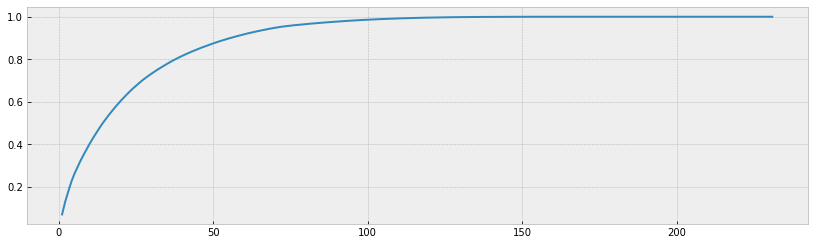

Number features: 70
Total Variance Explained: 0.9507685163008079


In [36]:
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(vect_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

In [37]:
# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(vect_df)

# Finding the exact number of features that explain at least 99% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_9 = len(total_explained_variance[total_explained_variance>=.99])
n_to_reach_9 = vect_df.shape[1] - n_over_9

print("PCA reduces the # of features from", vect_df.shape[1], 'to', n_to_reach_9)

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_9)

# Fitting and transforming the dataset to the stated number of features
df_pca = pca.fit_transform(vect_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
pca.explained_variance_ratio_.cumsum()[-1]

PCA reduces the # of features from 231 to 106


0.9899836477906552

----

Hierarchical Agglomerative Clustering:

In [38]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [39]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 11, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# The DF for evaluation
eval_df = df_pca

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    clust = AgglomerativeClustering(n_clusters=i, linkage='complete')
    
    clust.fit(eval_df)
    
    cluster_assignments = clust.labels_
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabasz_score(eval_df, cluster_assignments))
    
    s_scores.append(silhouette_score(eval_df, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(eval_df, cluster_assignments))

In [40]:
def cluster_eval(y, x):
    """
    Prints the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('bmh')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

The Calinski-Harabasz Score (find max score):
Max Value:
Cluster #    Cluster Score
4      37.757295

Min Value:
Cluster #    Cluster Score
3      23.546282


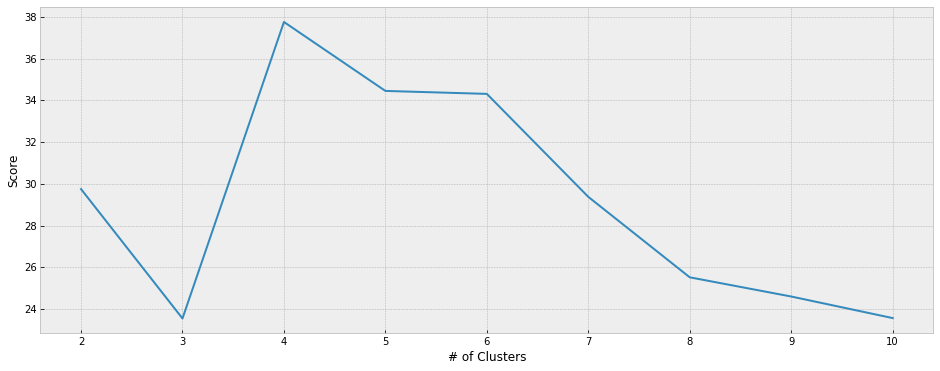


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
2        0.07273

Min Value:
Cluster #     Cluster Score
10       0.028581


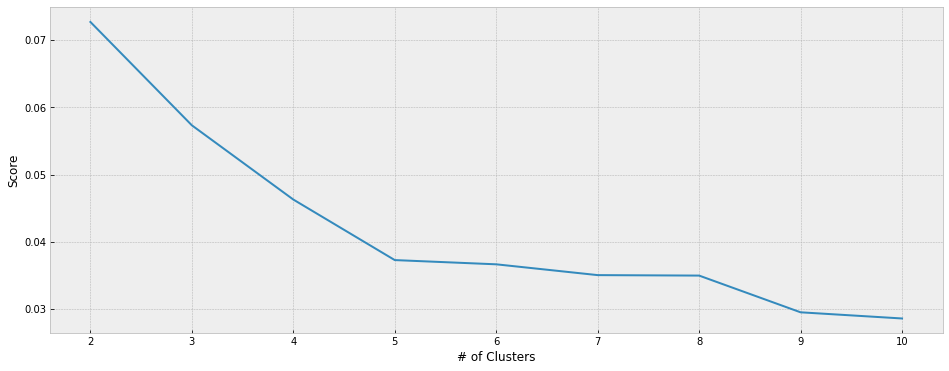


The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
2       4.021985

Min Value:
Cluster #    Cluster Score
8       2.934338


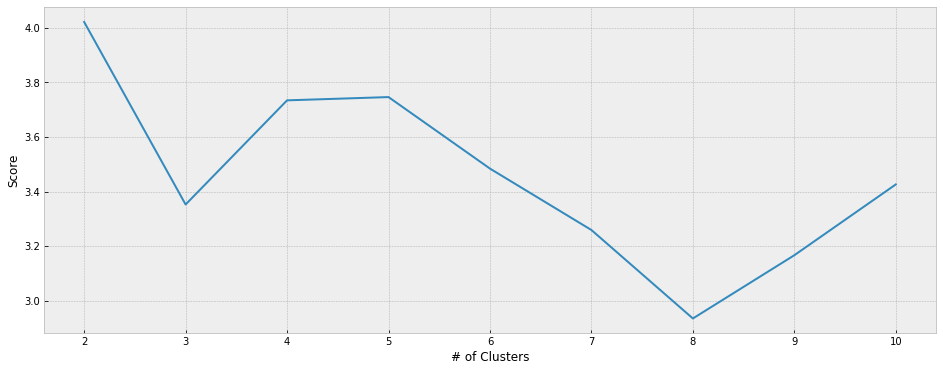

In [41]:
print("The Calinski-Harabasz Score (find max score):")
cluster_eval(ch_scores, cluster_cnt)

print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)

In [42]:
# Instantiating HAC based on the optimum number of clusters found
hac = AgglomerativeClustering(n_clusters=5, linkage='complete')

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
asd['Cluster #'] = cluster_assignments

vect_df['Cluster #'] = cluster_assignments

----

Cluster column representing data points in the respective cluster.

In [44]:
asd['Cluster #']

0       1
1       0
2       1
3       3
4       0
       ..
1419    0
1420    0
1421    3
1422    3
1423    1
Name: Cluster #, Length: 1424, dtype: int64